<a href="https://colab.research.google.com/github/jihun0423/Object-detection/blob/main/Ultralytics_yolov3_train_oxpet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ultralytics Yolo v3 설치

In [1]:
!git clone https://github.com/ultralytics/yolov3
!cd yolov3;pip install -qr requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 10843, done.
remote: Counting objects: 100% (765/765), done.
remote: Compressing objects: 100% (402/402), done.
remote: Total 10843 (delta 501), reused 574 (delta 362), pack-reused 10078
Receiving objects: 100% (10843/10843), 9.87 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (7300/7300), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [2]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.1+cu118 (NVIDIA A100-SXM4-40GB)


### Oxford Pet Dataset 다운로드
* Oxford Pet 데이터를 다운로드 후 /content/data 디렉토리에 압축 해제.

In [3]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2023-08-17 05:02:03--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-08-17 05:02:04--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-08-17 05:02:06--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

In [4]:
# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

### Oxford Pet Dataset 리뷰 및 학습/검증 데이터 세트로 분리
*  Pandas DataFrame으로 메타데이터 생성하고 이를 이용하여 학습과 검증 데이터 세트로 분리

In [5]:
# Ultralytics Yolo images와 labels 디렉토리를 train, val 용으로 생성
!mkdir /content/ox_pet;
!cd /content/ox_pet; mkdir images; mkdir labels;
!cd /content/ox_pet/images; mkdir train; mkdir val
!cd /content/ox_pet/labels; mkdir train; mkdir val

In [9]:
import pandas as pd

df=pd.read_csv('/content/data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
df

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
3675,yorkshire_terrier_187,37,2,25
3676,yorkshire_terrier_188,37,2,25
3677,yorkshire_terrier_189,37,2,25
3678,yorkshire_terrier_18,37,2,25


In [7]:
'''
for index, row in pet_df.iterrows():
  print(index, row['anno_filepath'])
'''

"\nfor index, row in pet_df.iterrows():\n  print(index, row['anno_filepath'])\n"

In [18]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 전체 image/annotation 파일명을 가지는 리스트 파일명을 입력 받아 메타 파일용 DataFrame 및 학습/검증용 DataFrame 생성.
def make_train_valid_df(list_filepath, img_dir, anno_dir, test_size=0.1):
  pet_df = pd.read_csv(list_filepath, sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
  #class_name은 image 파일명에서 맨 마지막 '_' 문자열 앞까지에 해당.
  pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])

  # image 파일명과 annotation 파일명의 절대경로 컬럼 추가
  pet_df['img_filepath'] = img_dir + pet_df['img_name']+'.jpg'
  pet_df['anno_filepath'] = anno_dir + pet_df['img_name']+'.xml'
  # annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우가 있음. 이들의 경우 pet_df에서 해당 rows를 삭제함.
  pet_df = remove_no_annos(pet_df)

  # 전체 데이터의 10%를 검증 데이터로, 나머지는 학습 데이터로 분리.
  train_df, val_df = train_test_split(pet_df, test_size=test_size, stratify=pet_df['class_id'], random_state=2021)
  return pet_df, train_df, val_df

# annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우에 이들을 dataframe에서 삭제하기 위한 함수.
def remove_no_annos(df):
  remove_rows = []
  for index, row in df.iterrows():
    anno_filepath = row['anno_filepath']
    if not os.path.exists(anno_filepath):
      print('##### index:', index, anno_filepath, '가 존재하지 않아서 Dataframe에서 삭제함')
      #해당 DataFrame index를 remove_rows list에 담음.
      remove_rows.append(index)
  # DataFrame의 index가 담긴 list를 drop()인자로 입력하여 해당 rows를 삭제
  df = df.drop(remove_rows, axis=0, inplace=False)
  return df


pet_df, train_df, val_df = make_train_valid_df('/content/data/annotations/trainval.txt',
                                               '/content/data/images/', '/content/data/annotations/xmls/', test_size=0.1)

##### index: 4 /content/data/annotations/xmls/Abyssinian_104.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 262 /content/data/annotations/xmls/Bengal_111.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 1456 /content/data/annotations/xmls/samoyed_10.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2128 /content/data/annotations/xmls/Bengal_175.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2395 /content/data/annotations/xmls/Egyptian_Mau_14.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2402 /content/data/annotations/xmls/Egyptian_Mau_156.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 2427 /content/data/annotations/xmls/Egyptian_Mau_186.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 3177 /content/data/annotations/xmls/Ragdoll_199.xml 가 존재하지 않아서 Dataframe에서 삭제함
##### index: 3246 /content/data/annotations/xmls/saint_bernard_15.xml 가 존재하지 않아서 Dataframe에서 삭제함


In [20]:
#print(train_df['class_name'].value_counts())
pet_df.head()

,img_name,class_id,etc1,etc2,class_name,img_filepath,anno_filepath
0,Abyssinian_100,1,1,1,Abyssinian,/content/data/images/Abyssinian_100.jpg,/content/data/annotations/xmls/Abyssinian_100.xml
1,Abyssinian_101,1,1,1,Abyssinian,/content/data/images/Abyssinian_101.jpg,/content/data/annotations/xmls/Abyssinian_101.xml
2,Abyssinian_102,1,1,1,Abyssinian,/content/data/images/Abyssinian_102.jpg,/content/data/annotations/xmls/Abyssinian_102.xml
3,Abyssinian_103,1,1,1,Abyssinian,/content/data/images/Abyssinian_103.jpg,/content/data/annotations/xmls/Abyssinian_103.xml
5,Abyssinian_105,1,1,1,Abyssinian,/content/data/images/Abyssinian_105.jpg,/content/data/annotations/xmls/Abyssinian_105.xml


In [21]:
import os

for index, row in pet_df.iterrows():
  anno_filepath = row['anno_filepath']
  if not os.path.exists(anno_filepath):
    print(anno_filepath)

### Oxford Pet 데이터 세트의 annotation을 Ultralytics Yolo format으로 생성.
* annotation용 xml 파일을 txt 파일로 변환
* 하나의 이미지는 하나의 txt 파일로 변환
* 확장자를 제외한 이미지의 파일명과 annotation 파일명이 서로 동일해야 함.
* 하나의 xml annotation 파일을 Yolo 포맷용 txt 파일로 변환하는 함수 생성
* voc annotation의 좌상단(Top left: x1, y1), 우하단(Bottom right: x2, y2) 좌표를 Bounding Box 중심 좌표(Center_x, Center_y)와 너비(width), 높이(height)로 변경
* 중심 좌표와 너비, 높이는 원본 이미지 레벨로 scale 되어야 함. 모든 값은 0~1 사이 값으로 변환됨.
* class_id는 여러개의 label들을 0 부터 순차적으로 1씩 증가시켜 id 부여

In [22]:
# Class 명을 부여. Class id는 자동적으로 CLASS_NAMES 개별 원소들을 순차적으로 0부터 36까지 부여
CLASS_NAMES = pet_df['class_name'].unique().tolist()
print(CLASS_NAMES)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [33]:
pet_df['class_name'].value_counts()

array(['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier',
       'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer',
       'British_Shorthair', 'chihuahua', 'Egyptian_Mau',
       'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
       'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond',
       'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland',
       'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue',
       'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu',
       'Siamese', 'Sphynx', 'staffordshire_bull_terrier',
       'wheaten_terrier', 'yorkshire_terrier'], dtype=object)

In [24]:
import glob
import xml.etree.ElementTree as ET

# 1개의 voc xml 파일을 Yolo 포맷용 txt 파일로 변경하는 함수
def xml_to_txt(input_xml_file, output_txt_file, object_name):
  # ElementTree로 입력 XML파일 파싱.
  tree = ET.parse(input_xml_file)
  root = tree.getroot()
  img_node = root.find('size')
  # img_node를 찾지 못하면 종료
  if img_node is None:
    return None
  # 원본 이미지의 너비와 높이 추출.
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # xml 파일내에 있는 모든 object Element를 찾음.
  value_str = None
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):
        # bndbox를 찾아서 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 추출.
        xmlbox = obj.find('bndbox')
        x1 = int(xmlbox.find('xmin').text)
        y1 = int(xmlbox.find('ymin').text)
        x2 = int(xmlbox.find('xmax').text)
        y2 = int(xmlbox.find('ymax').text)
        # 만약 좌표중에 하나라도 0보다 작은 값이 있으면 종료.
        if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
          break
        # object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 convert_yolo_coord()함수 호출.
        class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2)
        # 변환된 yolo 좌표를 object 별로 출력 text 파일에 write
        value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, w_norm, h_norm)
        output_fpointer.write(value_str+'\n')
        # debugging용으로 아래 출력
        print(object_name, value_str)

# object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환
def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출.
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산.
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1
  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)


In [25]:
 class_id = CLASS_NAMES.index('yorkshire_terrier')
 print(class_id)

36


In [26]:
xml_to_txt('/content/data/annotations/xmls/Abyssinian_1.xml', '/content/ox_pet/labels/train/Abyssinian_1.txt', 'Abyssinian')

Abyssinian 0 0.6316667 0.2875 0.1533333 0.215


### VOC Format의 여러개 xml 파일들을 Yolo format으로 변환 후 Ultralytics directory 구조로 입력
* VOC XML 파일들이 있는 디렉토리와 변환하여 출력될 Yolo format txt파일들이 있을 디렉토리를 입력하여 파일들을 생성.

In [27]:
import shutil

def make_yolo_anno_file(df, tgt_images_dir, tgt_labels_dir):
  for index, row in df.iterrows():
    src_image_path = row['img_filepath']
    src_label_path = row['anno_filepath']
    # 이미지 1개당 단 1개의 오브젝트만 존재하므로 class_name을 object_name으로 설정.
    object_name = row['class_name']
    # yolo format으로 annotation할 txt 파일의 절대 경로명을 지정.
    target_label_path = tgt_labels_dir + row['img_name']+'.txt'
    # image의 경우 target images 디렉토리로 단순 copy
    shutil.copy(src_image_path, tgt_images_dir)
    # annotation의 경우 xml 파일을 target labels 디렉토리에 Ultralytics Yolo format으로 변환하여  만듬
    xml_to_txt(src_label_path, target_label_path, object_name)

# train용 images와 labels annotation 생성.
make_yolo_anno_file(train_df, '/content/ox_pet/images/train/', '/content/ox_pet/labels/train/')
# val용 images와 labels annotation 생성.
make_yolo_anno_file(val_df, '/content/ox_pet/images/val/', '/content/ox_pet/labels/val/')

Birman 6 0.568 0.3183183 0.248 0.3903904
Birman 6 0.4825 0.233 0.43 0.346
leonberger 19 0.153 0.1674938 0.23 0.2158809
english_cocker_spaniel 12 0.598 0.3918919 0.476 0.7297297
Sphynx 33 0.5045181 0.22 0.4006024 0.212
newfoundland 22 0.356 0.5373333 0.3 0.3653333
pomeranian 24 0.52 0.4155556 0.36 0.5466667
saint_bernard 28 0.528 0.3426667 0.488 0.5626667
havanese 16 0.497 0.324 0.374 0.3973333
wheaten_terrier 35 0.429 0.2272727 0.278 0.4121212
yorkshire_terrier 36 0.408 0.404 0.404 0.4453333
havanese 16 0.62 0.3253333 0.224 0.2506667
scottish_terrier 30 0.671 0.4055556 0.554 0.8055556
newfoundland 22 0.663 0.3133333 0.374 0.4933333
scottish_terrier 30 0.443 0.3373333 0.294 0.296
german_shorthaired 14 0.4219219 0.512 0.5015015 0.208
Russian_Blue 27 0.73 0.3506787 0.272 0.3393665
Bombay 7 0.5761079 0.3222997 0.265896 0.3797909
Siamese 32 0.427 0.438 0.738 0.872
Siamese 32 0.495509 0.416 0.511976 0.344
Bombay 7 0.2663043 0.3 0.3695652 0.256
beagle 4 0.405 0.2963526 0.438 0.4468085
Birman 

### Oxford Pet Dataset 학습 수행.
* 생성된 Directory 구조에 맞춰서 dataset용 yaml 파일 생성.  

In [28]:
!wget -O /content/ox_pet/ox_pet.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml

--2023-08-17 05:33:46--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 754 [text/plain]
Saving to: ‘/content/ox_pet/ox_pet.yaml’

/content/ox_pet/ox_ 100%[===================>]     754  --.-KB/s    in 0s      

2023-08-17 05:33:46 (83.4 MB/s) - ‘/content/ox_pet/ox_pet.yaml’ saved [754/754]



In [29]:
# Google Drive 접근을 위한 Mount 적용.
import os, sys
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
# soft link로 Google Drive Directory 연결.
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 123.ipynb		   'London Bike.ipynb'
'23년_2월 1주.xlsx'	    LondonBikePrediction
'23년_2월 2주.xlsx'	    london_bike_preprocessed.csv
'23년_2월 3주.xlsx'	    london_merged.csv
'23년_3월 3주.xlsx'	    open
'23년_3월 4주.xlsx'	   'open (2)'
 baseball.ipynb		    plotly.ipynb
 Baseball_pitcher_predict   pracimg
 baseball_stat_test.pkl     selenium.ipynb
 baseball_stat_train.pkl   'stats (4).csv'
 baseball_stat_valid.pkl   'stats (6).csv'
 book			   'stats (7).csv'
 book.ipynb		   'stats (8).csv'
 chromedriver.exe	   'under over 비교용 오버샘플링'
'Colab Notebooks'	    YOLO-V1
 dash.ipynb		   '각종 코드 연습'
 data1_scale.csv	    감귤.ipynb
 deeplearningbro	   '데이콘 한솔 이미지 분류'
 DLCV-master		   '스펙들 정리.txt'
 Faster-RCNN		   '전처리, ML, DL 코드들 모음.ipynb'
 logs.log		   '핀다 프로젝트'


In [31]:
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생.
!mkdir "/mydrive/ultra_workdir"

In [32]:
###  10번 미만 epoch는 좋은 성능이 안나옴. 최소 30번 이상 epoch 적용.
!cd /content/yolov3; python train.py --img 640 --batch 16 --epochs 20 --data /content/ox_pet/ox_pet.yaml --weights yolov3.pt --project=/mydrive/ultra_workdir \
                                     --name pet --exist-ok

train: weights=yolov3.pt, cfg=, data=/content/ox_pet/ox_pet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/mydrive/ultra_workdir, name=pet, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 15921, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 15921 (delta 16), reused 24 (delta 9), pack-reused 15880
Receiving objects: 100% (15921/15921), 14.60 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (10915/10915), done.
From https://github.com/ultralytics/yolov5
 * [new branch]       

### 학습된 모델 파일을 이용하여 Inference 수행.
* 이미지 파일과 영상 파일로 inference 수행.

In [34]:
# image 파일 inference
!cd yolov3;python detect.py --source /content/data/images/pug_100.jpg --weights /mydrive/ultra_workdir/pet/weights/best.pt --conf 0.2 \
                            --project=/content/data/output --name=run_image --exist-ok --line-thickness 2

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/images/pug_100.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3 🚀 v9.6.0-105-g44cb63f6 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 190 layers, 61691290 parameters, 0 gradients, 155.2 GFLOPs
image 1/1 /content/data/images/pug_100.jpg: 640x448 1 pug, 73.0ms
Speed: 0.6ms pre-process, 73.0ms inference, 99.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/data/output/run_image


In [35]:
### 영상 파일 download
!wget -O /content/data/ox_dog.mp4  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true

--2023-08-17 05:56:44--  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4 [following]
--2023-08-17 05:56:44--  https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4 [following]
--2023-08-17 05:56:45--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

In [36]:
!cd yolov3; python detect.py --source /content/data/ox_dog.mp4 --weights /mydrive/ultra_workdir/pet/weights/best.pt \
                  --project /content/data/output --name run_video --exist-ok --line-thickness 3 --conf 0.4 --iou=0.6

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/ox_dog.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.6, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_video, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3 🚀 v9.6.0-105-g44cb63f6 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 190 layers, 61691290 parameters, 0 gradients, 155.2 GFLOPs
video 1/1 (1/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, 74.4ms
video 1/1 (2/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, 7.7ms
video 1/1 (3/727) /content/data/ox_dog.mp4: 384x640 1 yorkshire_terrier, 7.2ms
video 1/1 (4/727) /content/data/ox_dog.mp4: 384x640 1 yorkshi

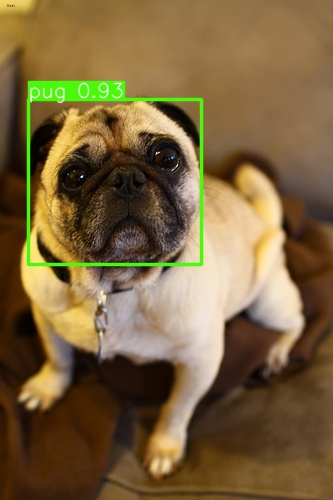

In [42]:
from IPython.display import Image, clear_output

Image(filename='/content/data/output/run_image/pug_100.jpg', width=400)

detect: weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], source=/content/data/images/boxer_100.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3 🚀 v9.6.0-105-g44cb63f6 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 190 layers, 61691290 parameters, 0 gradients, 155.2 GFLOPs
image 1/1 /content/data/images/boxer_100.jpg: 448x640 1 boxer, 70.2ms
Speed: 0.5ms pre-process, 70.2ms inference, 111.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/data/output/run_image


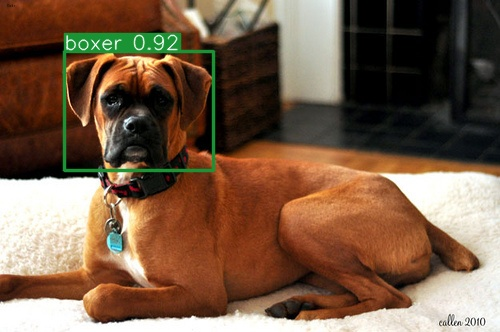

In [43]:
!cd yolov3;python detect.py --source /content/data/images/boxer_100.jpg --weights /mydrive/ultra_workdir/pet/weights/best.pt --conf 0.2 \
                            --project=/content/data/output --name=run_image --exist-ok --line-thickness 2

Image(filename='/content/data/output/run_image/boxer_100.jpg', width=400)

### test.py를 이용하여 Test 데이터를 Evalutation하기

In [40]:
# Run YOLOv3 on COCO val2017
!cd yolov3; python val.py --weights /mydrive/ultra_workdir/pet/weights/best.pt  --data /content/ox_pet/ox_pet.yaml \
                           --project /content/data/output --name=test_result --exist-ok --img 640 --iou 0.65



val: data=/content/ox_pet/ox_pet.yaml, weights=['/mydrive/ultra_workdir/pet/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/data/output, name=test_result, exist_ok=True, half=False, dnn=False
YOLOv3 🚀 v9.6.0-105-g44cb63f6 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 190 layers, 61691290 parameters, 0 gradients, 155.2 GFLOPs
val: Scanning /content/ox_pet/labels/val.cache... 368 images, 0 backgrounds, 0 corrupt: 100% 368/368 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 12/12 [00:05<00:00,  2.21it/s]
                   all        368        368      0.809       0.91       0.92      0.805
            Abyssinian        368         10       0.84        0.8    

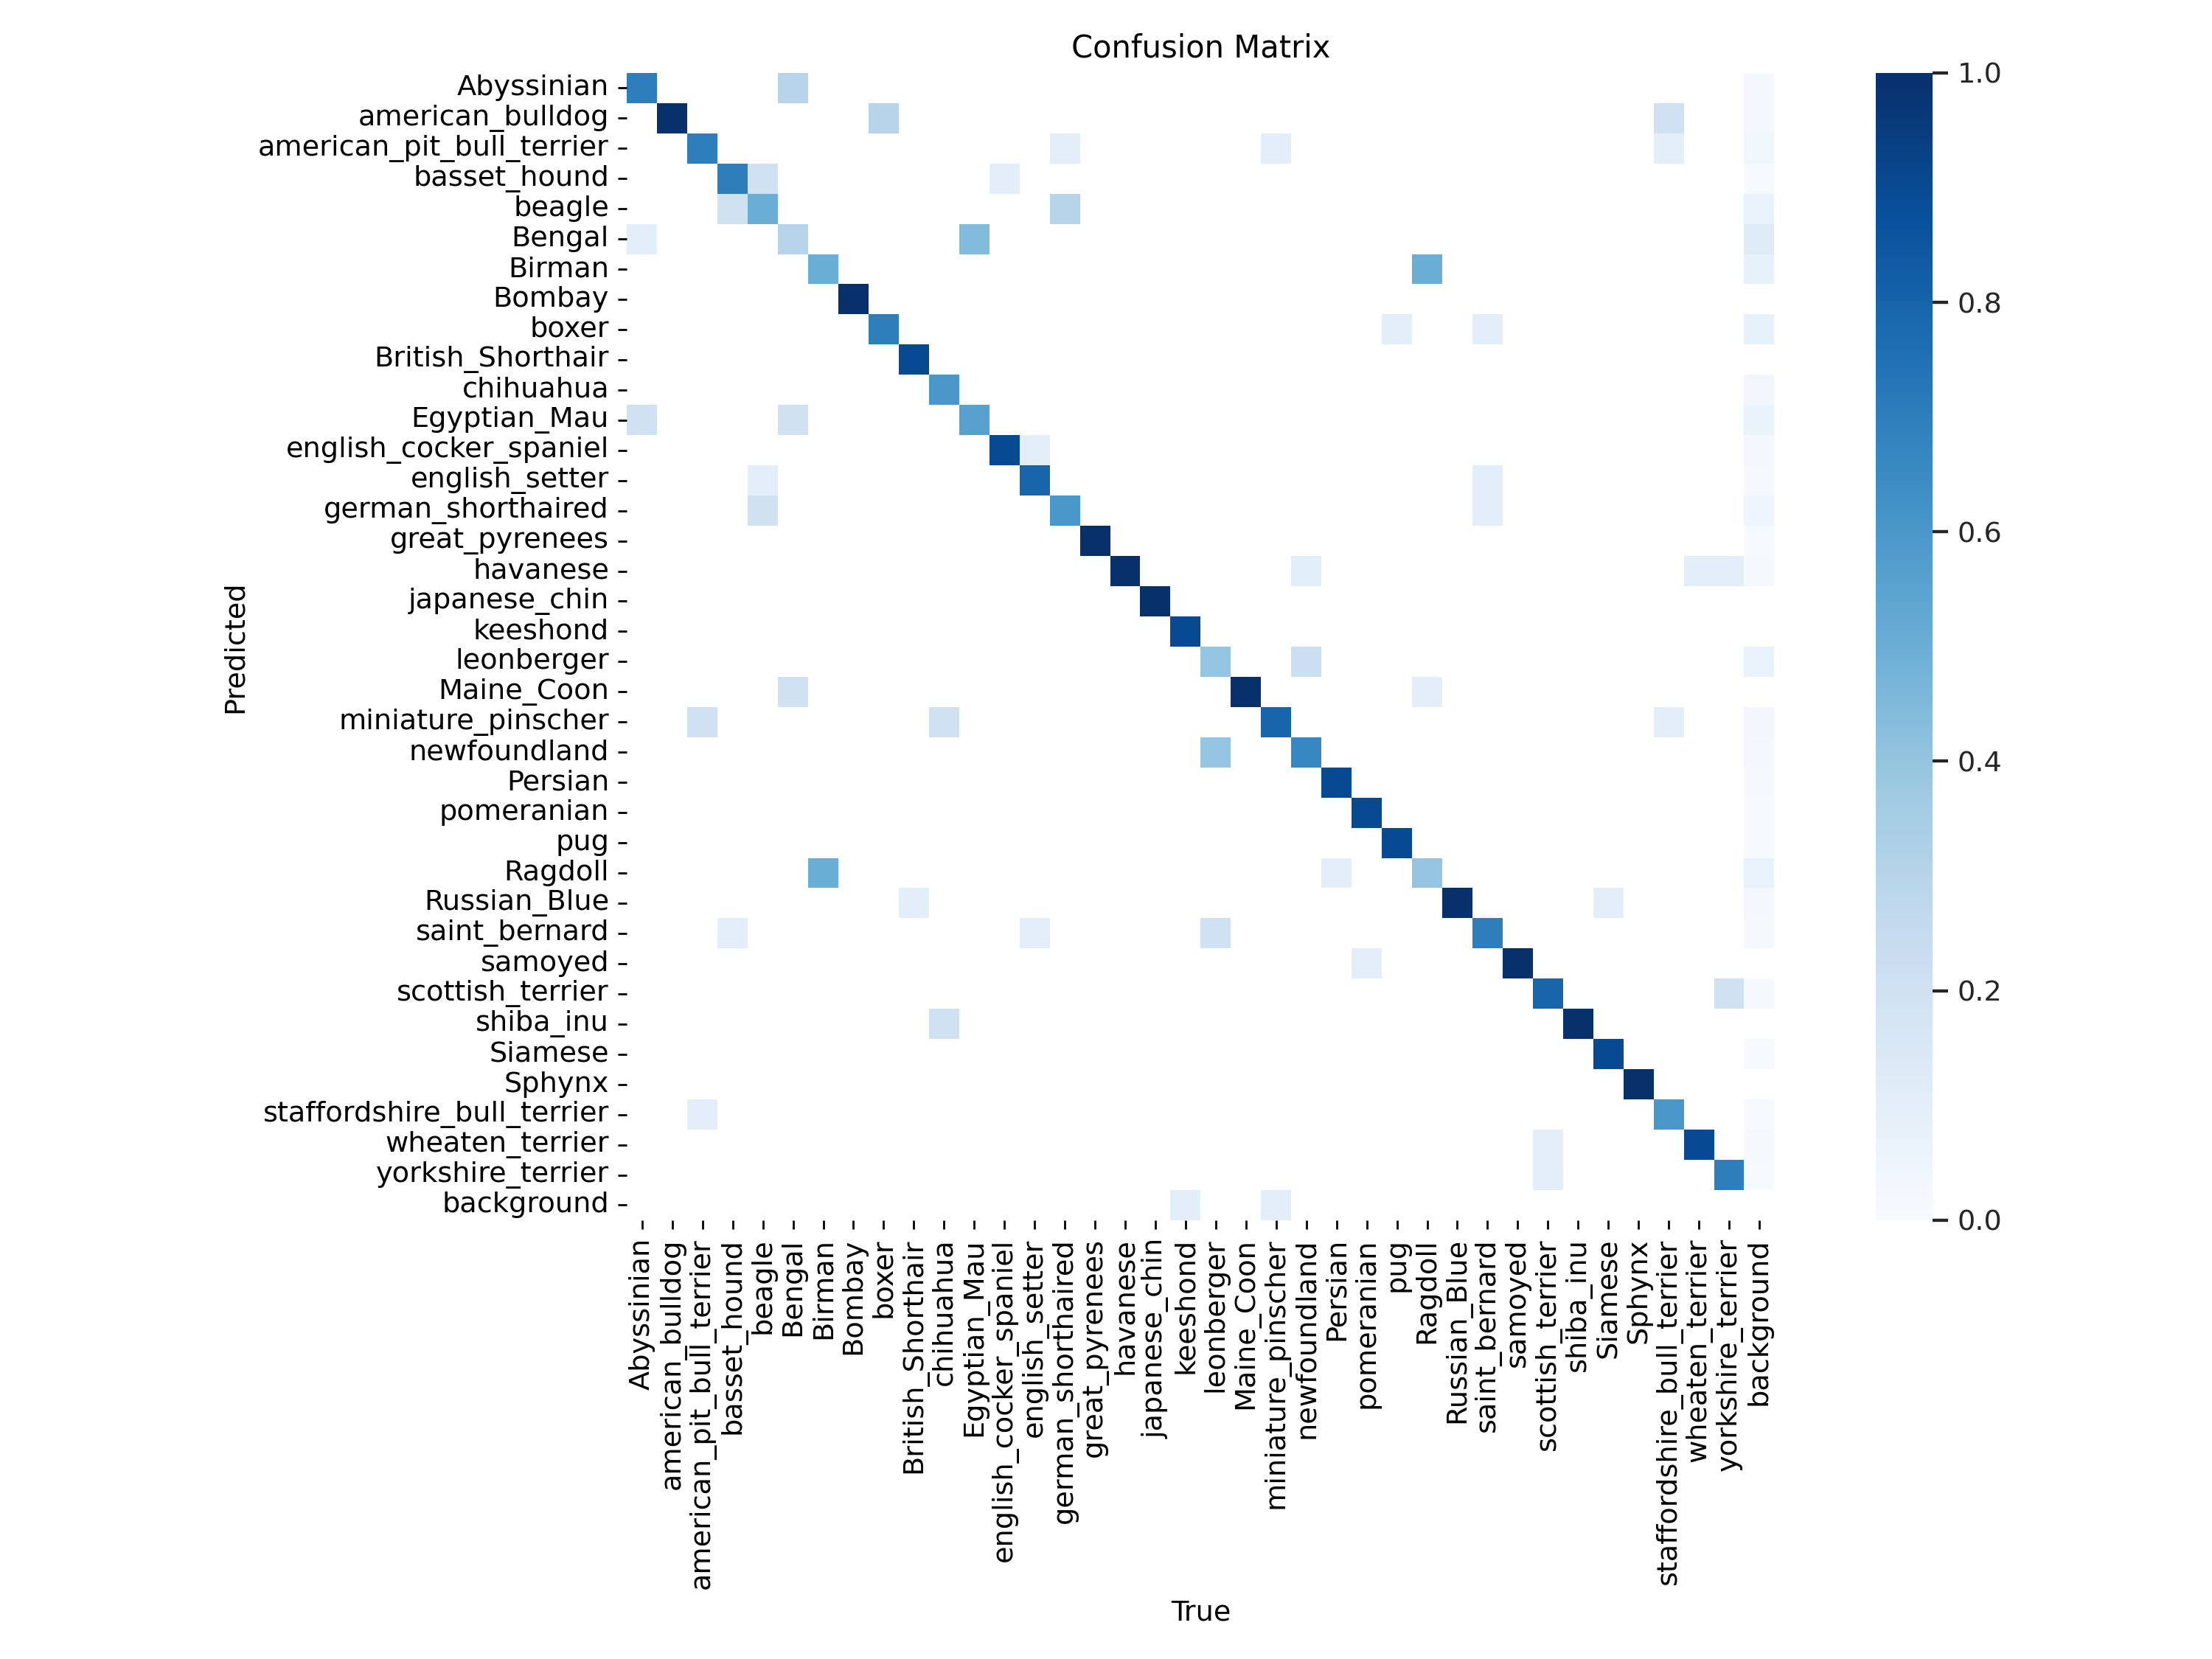

In [44]:
Image(filename='/content/data/output/test_result/confusion_matrix.png', width=800)